## 1. Data Processing

Our dataset contains `126 rows and 19476 columns`. The objective is to develop a supervised learning model to predict
severe COVID-19 hospital admissions by using as predictors the genome sequencing of patients.
Since our dataset is high dimensional data which contains 126 rows and 19476 columns, we will need to reduce the dataset dimensions so we will be able to reduce the complexity and computaional time.
- __We will apply two methods to reduce the dimensions :__

__1- PCA__

__2- Feature selection using RandomForest__

=======================================================================================================================

### 1.1 Data Processing First Method using PCA:

In [1]:
#Importing the necessary packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
# reading the dataset
df=pd.read_csv('covid_data.csv')

In [3]:
df.head()

,Sample,Age,Sex,Severity,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,C1,39,male,NonICU,0.49,0.00,0.21,0.04,0.07,0.0,...,2.84,4.22,0.95,1.63,15.51,0.06,8.17,363.01,19.17,6.05
1,C2,63,male,NonICU,0.29,0.00,0.14,0.00,0.00,0.0,...,3.55,12.15,0.60,1.15,15.62,0.14,8.20,399.80,15.72,4.12
2,C3,33,male,NonICU,0.26,0.00,0.03,0.02,0.00,0.0,...,1.34,2.79,0.18,0.32,17.67,0.28,3.62,430.35,13.95,1.81
3,C4,49,male,NonICU,0.45,0.01,0.09,0.07,0.00,0.0,...,3.71,5.87,1.40,2.21,15.61,0.27,7.88,209.25,14.78,7.15
4,C5,49,male,NonICU,0.17,0.00,0.00,0.05,0.07,0.0,...,1.44,4.46,0.28,0.55,9.34,0.07,5.96,272.91,8.69,2.70


In [4]:
# drop the sample feature from dataset since its not important
df.drop('Sample',axis=1,inplace=True)

In [5]:
# Checking if there is missing values in the dataframe
df.isnull().sum()

Age         0
Sex         0
Severity    0
A1BG        0
A1CF        0
           ..
ZYG11A      0
ZYG11B      0
ZYX         0
ZZEF1       0
ZZZ3        0
Length: 19475, dtype: int64

In [6]:
# Checking the count missing values in the dataframe
df.isnull().sum().sum()

0

- We have 2 categorical features in the dataset, so we need to see the proportions of gender and Severity so we will maintain the same proportions when we split the data into train and test. for that we will use Stratify sampling technique.

In [7]:
# checking the Gender proportion of the data
df.Sex.value_counts()

male       74
female     51
unknown     1
Name: Sex, dtype: int64

In [8]:
#checking the target feature 'Severity' proportion of the data
df.Severity.value_counts()

ICU       66
NonICU    60
Name: Severity, dtype: int64

In [9]:
# since we have one unkown gender, we will fill it with the mode which is male the most frequent class 
df['Sex'].replace({'unknown':'male'}, inplace=True)

In [10]:
df.Sex.value_counts()

male      75
female    51
Name: Sex, dtype: int64

- Now we will create the Stratify samplming which will split the data in the train and test based on the shared characteristics or attributes of the members in the gender and Severity.

In [11]:
df['Stratify']=df['Sex']+" "+df['Severity']
(df['Stratify'].value_counts() / len(df)).sort_values(ascending=False)

male ICU         0.333333
male NonICU      0.261905
female NonICU    0.214286
female ICU       0.190476
Name: Stratify, dtype: float64

__Note__ that we have `33% of our data are male and ICU` ,`26% of our data male NonICU`, `21% female NonICU` and last `19% female ICU`.
We will take on consideration those proportions when we split the data into train and test. its very important to train the model and test it on the same proportions in order to avoid the bais and imbalance splitting

In [12]:
df['Stratify']

0        male NonICU
1        male NonICU
2        male NonICU
3        male NonICU
4        male NonICU
           ...      
121      male NonICU
122    female NonICU
123    female NonICU
124      male NonICU
125         male ICU
Name: Stratify, Length: 126, dtype: object

In [13]:
# saving it in seperate list to use it when we split the data
Stratify=df['Stratify']

In [14]:
# we will drop this column from our dataset
df.drop('Stratify',axis=1,inplace=True)

In [15]:
# now we noticed there are 1249 dublicated columns which need to be removed
df2= df.T.drop_duplicates().T

In [16]:
# now the dataset contain 18226 features 
df2

,Age,Sex,Severity,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,39,male,NonICU,0.49,0.0,0.21,0.04,0.07,0.0,0.03,...,2.84,4.22,0.95,1.63,15.51,0.06,8.17,363.01,19.17,6.05
1,63,male,NonICU,0.29,0.0,0.14,0.0,0.0,0.0,0.05,...,3.55,12.15,0.6,1.15,15.62,0.14,8.2,399.8,15.72,4.12
2,33,male,NonICU,0.26,0.0,0.03,0.02,0.0,0.0,0.07,...,1.34,2.79,0.18,0.32,17.67,0.28,3.62,430.35,13.95,1.81
3,49,male,NonICU,0.45,0.01,0.09,0.07,0.0,0.0,0.0,...,3.71,5.87,1.4,2.21,15.61,0.27,7.88,209.25,14.78,7.15
4,49,male,NonICU,0.17,0.0,0.0,0.05,0.07,0.0,0.0,...,1.44,4.46,0.28,0.55,9.34,0.07,5.96,272.91,8.69,2.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,63,male,NonICU,0.3,0.0,0.02,0.02,0.0,0.0,0.0,...,0.26,1.01,0.13,0.46,5.93,0.24,1.58,447.14,3.04,1.0
122,42,female,NonICU,0.7,0.0,0.02,0.01,0.0,0.0,0.0,...,0.64,0.83,0.18,0.73,8.75,0.12,1.57,748.55,4.55,1.56
123,32,female,NonICU,0.75,0.0,0.27,0.0,0.06,0.0,0.0,...,1.18,2.14,0.41,1.29,14.93,0.14,5.05,437.62,10.34,3.99
124,62,male,NonICU,2.8,0.0,0.04,0.0,0.0,0.0,0.0,...,0.42,0.61,0.19,0.45,4.77,0.33,1.07,369.66,1.83,0.96


In [17]:
# labelEncoder for severity and sex
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

In [18]:
# we used map function to label encode the Severity
df2['Severity']= df2['Severity'].map({'ICU':1,'NonICU':0})

In [19]:
#df2['Severity'] = label.fit_transform(df2['Severity'].values)

In [20]:
df2['Sex'] = label.fit_transform(df2['Sex'].values)

In [21]:
df2.Severity.value_counts()

1    66
0    60
Name: Severity, dtype: int64

In [22]:
df2.head()

,Age,Sex,Severity,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,39,1,0,0.49,0.0,0.21,0.04,0.07,0.0,0.03,...,2.84,4.22,0.95,1.63,15.51,0.06,8.17,363.01,19.17,6.05
1,63,1,0,0.29,0.0,0.14,0.0,0.0,0.0,0.05,...,3.55,12.15,0.6,1.15,15.62,0.14,8.2,399.8,15.72,4.12
2,33,1,0,0.26,0.0,0.03,0.02,0.0,0.0,0.07,...,1.34,2.79,0.18,0.32,17.67,0.28,3.62,430.35,13.95,1.81
3,49,1,0,0.45,0.01,0.09,0.07,0.0,0.0,0.0,...,3.71,5.87,1.4,2.21,15.61,0.27,7.88,209.25,14.78,7.15
4,49,1,0,0.17,0.0,0.0,0.05,0.07,0.0,0.0,...,1.44,4.46,0.28,0.55,9.34,0.07,5.96,272.91,8.69,2.7


In [23]:
# now we will create X, Y
y = df2['Severity']
x = df2.drop('Severity', axis=1)

__Applying PCA__ :

In PCA or principal component analysis, its techique used to reduce the dimensionality of large data sets by transforming them into a smaller set of variables that retain most of the information found in the orginal dataset. Data sets with fewer variables naturally mean less accuracy, but the key to dimensionality reduction is to trade some accuracy for simplicity.


We will be applying PCA on the Genes only, to do so, we will remove Sex and Age from the dataset and apply PCA then add them again.

- the idea of applying PCA on the Genes only that Age and Gender are not correlated with the Genes features, and PCA will remove multi-collinearity between the Genes features which improves the interpretation of the parameters of the machine learning model.

- PCA steps:

    1- scaling the data
    
    2- compute the coveriance matrix
    
    3- compute the eigenvectors and eigenvalues from the coveraince matrix to constract the PCA components.

 Components are constructed in such a way that the first component represents the largest variance in the data set and so on.

In [24]:
# creating catagerical dataframe for sex feature since we dont need to scale it
df_sex=df2.Sex
Sex_df = pd.DataFrame(df_sex, columns=['Sex'])
Sex_df

,Sex
0,1
1,1
2,1
3,1
4,1
...,...
121,1
122,0
123,0
124,1


In [25]:
# now we will remove Sex from the dataset
X = x.drop('Sex', axis=1)

In [26]:
X.head()

,Age,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,39,0.49,0.0,0.21,0.04,0.07,0.0,0.03,18.92,4.07,...,2.84,4.22,0.95,1.63,15.51,0.06,8.17,363.01,19.17,6.05
1,63,0.29,0.0,0.14,0.0,0.0,0.0,0.05,18.68,3.0,...,3.55,12.15,0.6,1.15,15.62,0.14,8.2,399.8,15.72,4.12
2,33,0.26,0.0,0.03,0.02,0.0,0.0,0.07,13.85,1.83,...,1.34,2.79,0.18,0.32,17.67,0.28,3.62,430.35,13.95,1.81
3,49,0.45,0.01,0.09,0.07,0.0,0.0,0.0,22.11,4.22,...,3.71,5.87,1.4,2.21,15.61,0.27,7.88,209.25,14.78,7.15
4,49,0.17,0.0,0.0,0.05,0.07,0.0,0.0,8.45,1.17,...,1.44,4.46,0.28,0.55,9.34,0.07,5.96,272.91,8.69,2.7


__Applying MinMAX scaler to the dataset__ 

Note: we didnt remove Age feature since we need to scale it

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_n = scaler.fit_transform(X)

In [28]:
df_norm = pd.DataFrame(df_n, columns=X.columns)
df_norm.head()

,Age,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,0.260870,0.160000,0.0,0.238636,0.4,0.04,0.0,0.157895,0.566077,0.704545,...,0.341722,0.173540,0.486911,0.390123,0.493769,0.114286,0.638912,0.357671,0.968471,0.538175
1,0.608696,0.087273,0.0,0.159091,0.0,0.00,0.0,0.263158,0.556196,0.501894,...,0.435762,0.514175,0.303665,0.271605,0.498053,0.342857,0.641461,0.410926,0.787178,0.358473
2,0.173913,0.076364,0.0,0.034091,0.2,0.00,0.0,0.368421,0.357349,0.280303,...,0.143046,0.112113,0.083770,0.066667,0.577882,0.742857,0.252336,0.455148,0.694167,0.143389
3,0.405797,0.145455,0.5,0.102273,0.7,0.00,0.0,0.000000,0.697406,0.732955,...,0.456954,0.244416,0.722513,0.533333,0.497664,0.714286,0.614274,0.135098,0.737782,0.640596
4,0.405797,0.043636,0.0,0.000000,0.5,0.04,0.0,0.000000,0.135035,0.155303,...,0.156291,0.183849,0.136126,0.123457,0.253505,0.142857,0.451147,0.227248,0.417761,0.226257


In [29]:
# now after scaling Age and all the features, we will save it in seperate dataframe and remove it and then
# apply PCA on Genes
df_Age=df_norm.Age
Age_df = pd.DataFrame(df_Age, columns=['Age'])
Age_df.head()

,Age
0,0.260870
1,0.608696
2,0.173913
3,0.405797
4,0.405797


In [30]:
# removing age
df_norm = df_norm.drop('Age', axis=1)

In [31]:
#so now we have only genes remaining and we will apply PCA on it
df_norm.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,0.160000,0.0,0.238636,0.4,0.04,0.0,0.157895,0.566077,0.704545,0.0,...,0.341722,0.173540,0.486911,0.390123,0.493769,0.114286,0.638912,0.357671,0.968471,0.538175
1,0.087273,0.0,0.159091,0.0,0.00,0.0,0.263158,0.556196,0.501894,0.0,...,0.435762,0.514175,0.303665,0.271605,0.498053,0.342857,0.641461,0.410926,0.787178,0.358473
2,0.076364,0.0,0.034091,0.2,0.00,0.0,0.368421,0.357349,0.280303,0.0,...,0.143046,0.112113,0.083770,0.066667,0.577882,0.742857,0.252336,0.455148,0.694167,0.143389
3,0.145455,0.5,0.102273,0.7,0.00,0.0,0.000000,0.697406,0.732955,0.0,...,0.456954,0.244416,0.722513,0.533333,0.497664,0.714286,0.614274,0.135098,0.737782,0.640596
4,0.043636,0.0,0.000000,0.5,0.04,0.0,0.000000,0.135035,0.155303,0.0,...,0.156291,0.183849,0.136126,0.123457,0.253505,0.142857,0.451147,0.227248,0.417761,0.226257


In [32]:
from sklearn.decomposition import PCA

We will reduce the `18223`features of the Genes using PCA to 10 components which will contain information from all the genes features.

In [33]:
pca_model = PCA(n_components=10)

In [34]:
pca_10 = pca_model.fit_transform(df_norm)

In [35]:
#How much variance is explained by 10 principal components
np.sum(pca_model.explained_variance_ratio_)

0.6639915498787619

- 10 PCA componants explains `66.3%` of the overall information. its recommended to have Number of components which explain 85% of the data variance, but since we have low number of observations (126 rows) we chooses 10 components to reduce the complixity of the model and avoid overfitting. its expected that the model will not have high accuracy with this information lost around `33.7% `

In [36]:
PCA_df=pd.DataFrame(pca_10, columns=['PC1', 'PC2','PC3',
                                      'PC4','PC5','PC6',
                                      'PC7','PC8','PC9','PC10'])
PCA_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,19.467362,0.610147,-9.123242,-8.964858,10.878133,8.738040,6.530395,0.937861,1.831448,2.200847
1,12.156599,2.140342,-2.233645,-2.141676,-4.045874,6.582225,1.051435,2.202431,0.207123,-4.035432
2,-5.840824,-6.565041,-9.089379,-3.601348,6.280681,-5.356577,5.406956,-2.949167,-0.478803,-5.584290
3,27.537701,5.475659,0.030296,5.666787,0.538421,4.321981,-1.336073,3.920340,0.228881,-0.457304
4,-2.624312,-13.858577,2.710596,-1.523001,6.754335,-4.476231,0.567991,-1.710790,-2.456044,3.285687


In [37]:
# Adding sex and age using the concat function 
X_final=pd.concat([PCA_df, Age_df, Sex_df], axis=1)

In [38]:
X_final.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Age,Sex
0,19.467362,0.610147,-9.123242,-8.964858,10.878133,8.738040,6.530395,0.937861,1.831448,2.200847,0.260870,1
1,12.156599,2.140342,-2.233645,-2.141676,-4.045874,6.582225,1.051435,2.202431,0.207123,-4.035432,0.608696,1
2,-5.840824,-6.565041,-9.089379,-3.601348,6.280681,-5.356577,5.406956,-2.949167,-0.478803,-5.584290,0.173913,1
3,27.537701,5.475659,0.030296,5.666787,0.538421,4.321981,-1.336073,3.920340,0.228881,-0.457304,0.405797,1
4,-2.624312,-13.858577,2.710596,-1.523001,6.754335,-4.476231,0.567991,-1.710790,-2.456044,3.285687,0.405797,1


We will use Stratify sampling To avoid bias and imbalance spliting for target variable, which is the Severity, and gender in order to maintain the same distribution characteristics and balance of our target should be maintained in each split accordingly.

In [39]:
X_train,X_test,y_train,y_test=train_test_split(X_final,y,test_size=0.2,random_state=0,stratify=Stratify)

In [40]:
y_train.value_counts()

1    52
0    48
Name: Severity, dtype: int64

In [41]:
y_test.value_counts()

1    14
0    12
Name: Severity, dtype: int64

Note here we have maintain the same balance distribution of the target feature in the train and test split which is around `52%` 
ICU and `48%` Non-ICU and the same for gender


=======================================================================================================================

### 1.2 Data Processing Second Method feature selection using RF:

In [42]:
x.head()

,Age,Sex,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,39,1,0.49,0.0,0.21,0.04,0.07,0.0,0.03,18.92,...,2.84,4.22,0.95,1.63,15.51,0.06,8.17,363.01,19.17,6.05
1,63,1,0.29,0.0,0.14,0.0,0.0,0.0,0.05,18.68,...,3.55,12.15,0.6,1.15,15.62,0.14,8.2,399.8,15.72,4.12
2,33,1,0.26,0.0,0.03,0.02,0.0,0.0,0.07,13.85,...,1.34,2.79,0.18,0.32,17.67,0.28,3.62,430.35,13.95,1.81
3,49,1,0.45,0.01,0.09,0.07,0.0,0.0,0.0,22.11,...,3.71,5.87,1.4,2.21,15.61,0.27,7.88,209.25,14.78,7.15
4,49,1,0.17,0.0,0.0,0.05,0.07,0.0,0.0,8.45,...,1.44,4.46,0.28,0.55,9.34,0.07,5.96,272.91,8.69,2.7


In [43]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Severity, dtype: int64

- High-importance variables have a strong influence on outcome values, whereas low-importance variables might be left out, making the fit and prediction process simpler and faster. Choosing the top features based on importance means they are highly correlated with the target and not redundant which improve our model.

- In the process of building a tree, the Gini impurity is used to determine which variables should be split at each node which means the selection of the top features will be based on __Gini importance (or mean decrease impurity)__.

- Gini Impurity is measure how oftern a random chosen element would be incorrectly classified.

-  In In random forests, the more a feature decreases the impurity, the more important the feature is. The impurity decrease from each feature can be averaged across trees to determine the top importance features.

A random forest consists of hundreds of decision trees, each tree constructed from a random extract of observations and features from the dataset. Not every tree sees all features and observations from the dataset. Since we have 18225 features its important to increase the number of trees so we would have covered all the features and generalize the features improtance which will be extracted from all the trees. I have choosen number of trees to be 10000, the disadvange of this choice is the computaional time. 

In [255]:
# importing RF, since we have high dimensional dataset we increases the number of trees
from sklearn.ensemble import RandomForestClassifier
model_RF=RandomForestClassifier(n_estimators=10000, n_jobs=-1)

In [256]:
# fitting the data on the RF
model_RF.fit(x,y)

RandomForestClassifier(n_estimators=10000, n_jobs=-1)

In [257]:
# saving the featuree importance
feat_importances = pd.Series(model_RF.feature_importances_, index=x.columns)

__Since we have low number of observations (126 rows), We will select the top 15 features based in importance to simplfy our model and reduce the complixety, improve the performance and avoid overfitting__.

In [258]:
# choosing the top 15 features based in importance
features=pd.DataFrame(feat_importances.nlargest(15))

In [259]:
features.reset_index(inplace=True)

In [260]:
features

,index,0
0,PRR5L,0.003838
1,GALNT6,0.003453
2,PARP3,0.003347
3,GPR68,0.003323
4,SBK1,0.003189
5,UBA7,0.003095
6,TMEM229B,0.002757
7,CD4,0.002664
8,OPTN,0.002634
9,ARG1,0.002610


In [261]:
# to select the columns names 
top_features=features['index']
top_features

0        PRR5L
1       GALNT6
2        PARP3
3        GPR68
4         SBK1
5         UBA7
6     TMEM229B
7          CD4
8         OPTN
9         ARG1
10      CYB561
11       KLRG1
12       TNIP3
13       S1PR2
14      FCER1A
Name: index, dtype: object

In [262]:
# now selecting the  15 features from x which contain 18225 features
X_final_RF=x[top_features]

In [263]:
X_final_RF.head()

,PRR5L,GALNT6,PARP3,GPR68,SBK1,UBA7,TMEM229B,CD4,OPTN,ARG1,CYB561,KLRG1,TNIP3,S1PR2,FCER1A
0,8.8,10.67,7.13,1.68,3.27,118.12,29.49,184.46,23.56,26.52,9.29,7.98,0.38,3.37,11.02
1,7.72,4.53,3.11,3.43,2.32,59.82,6.03,78.82,15.79,109.8,11.22,12.0,0.41,1.29,23.93
2,4.0,2.43,3.96,1.59,1.19,96.52,6.32,32.52,17.46,123.78,11.01,5.02,0.29,1.03,10.86
3,18.2,7.09,3.12,4.02,3.52,61.91,10.96,108.4,29.42,9.31,10.41,24.14,0.58,1.75,91.8
4,7.44,1.34,1.99,1.71,0.61,49.13,10.32,15.69,11.07,43.66,6.51,11.22,0.39,0.88,12.07


Next step is to standardize the data before fitting it to SVC

In [264]:
from sklearn.preprocessing import StandardScaler

In [265]:
scale=StandardScaler()

In [266]:
X_scaled=scale.fit_transform(X_final_RF)

In [267]:
X_scaled=pd.DataFrame(X_scaled,columns=X_final_RF.columns)

In [268]:
X_scaled.head()

,PRR5L,GALNT6,PARP3,GPR68,SBK1,UBA7,TMEM229B,CD4,OPTN,ARG1,CYB561,KLRG1,TNIP3,S1PR2,FCER1A
0,0.619888,3.583725,2.876934,-0.323332,0.936075,2.922674,3.922179,3.027633,0.690113,-0.718651,0.756207,-0.280065,0.663619,3.451970,-0.318999
1,0.383799,0.595459,0.470287,0.680253,0.356536,0.453365,-0.099105,0.581315,-0.144385,-0.404538,1.219558,0.104136,0.804307,0.280616,0.261838
2,-0.429393,-0.426586,0.979155,-0.374944,-0.332812,2.007802,-0.049396,-0.490859,0.034973,-0.351809,1.169141,-0.562959,0.241553,-0.115804,-0.326197
3,2.674729,1.841381,0.476274,1.018604,1.088586,0.541888,0.745947,1.266303,1.319476,-0.783563,1.025095,1.264384,1.601543,0.981973,3.315395
4,0.322591,-0.957076,-0.200221,-0.306127,-0.686636,0.000588,0.636245,-0.880593,-0.651312,-0.654003,0.088791,0.029590,0.710515,-0.344507,-0.271758


Now the dataset is standardize and ready for SVC machine learning algorithm

In [269]:
# splitting the data based on Stratify sampling
X2_train,X2_test,y2_train,y2_test=train_test_split(X_scaled,y,test_size=0.2,stratify=Stratify)

## 2. Training and tuning

### 2.1 Training and tuning for first method PCA 

Now our data is ready for machine learning, below will be implementation of Support vector machine classifier.
Note that I applied Logistic regression, Decison tree, Random Forest, XGboost and SVC and i chooses the model which have the highest accuracy in consider of bais-variance trade off. 

The below observation was taken in consideration choosing the best model:
- Decison Tree, RandomForest,XGboost classifiers were overfitting (train score 1.0 and test score was much lower).
- Logistic Regression model was underfit and accuracy was low which means it didnt catch the true pattern.
- SVC have the best accuracy among the others and training score was closer to the test score.

__Now applying SVC__

Our goal with SVC is to create the best separating hyperplane to seperate the data into two classes ICU and NonICU.

In [59]:
from sklearn.svm import SVC

In [60]:
from sklearn.metrics import accuracy_score

In [61]:
SV=SVC()

In [62]:
# training the model
SV.fit(X_train,y_train)

SVC()

Checking the accuracy of the model performance

In [63]:
y_pred = SV.predict(X_test)

In [64]:
print('Model accuracy:',accuracy_score(y_test,y_pred)*100,'%')

Model accuracy: 76.92307692307693 %


In [65]:
print('Training score:',SV.score(X_train,y_train)*100,'%')
print('test score:',SV.score(X_test,y_test)*100,'%')

Training score: 87.0 %
test score: 76.92307692307693 %


The train accuracy is `87 %` and the test accuracy is `76.9%`. which means the model tend to overfit since we have around 11% difference in accuracy between the test and train accuracy __(which is the variance)__. So we will tune the hyperparameters in order to reduce the difference between train accuracy and test accuracy.

### Tuning hyperparameters for SVC



In SVC, There are 3 important hyperparameters which can be tuned to improve the model score. 
- `Kernel` parameter is used to separate the data by selecting the type of hyperplane. There are 4 types of hyperplanes that we can use to fit our model but we will use RBF kernel and linear since they are the most used one.
- `Gamma` gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
- `C` Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty. It is common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly.

We will use GridSearchCV method, which will choose the right set of parameters to tune our model by running all possible scenarios after feeding the range of values.

In [66]:
my_param_grid = {'C': [0.01,0.1,1,10,50], 'gamma': ['scale','auto',0.01,0.001,], 'kernel': ['rbf','linear']}

In [67]:
from sklearn.model_selection import GridSearchCV

In [68]:
# Grid search to tune the hyperparameters
grid = GridSearchCV(estimator=SVC(),param_grid= my_param_grid, refit = True, verbose=2, cv=5,scoring='accuracy' )

In [69]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....................C=0.01, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=aut

[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   0.2s
[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=10, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ...................

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 50],
                         'gamma': ['scale', 'auto', 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             scoring='accuracy', verbose=2)

In [70]:
#Below are the best parameters used to build the best accuracy model
grid.best_params_

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [71]:
print('Model accuracy after tuning:',grid.score(X_test,y_test)*100,'%')

Model accuracy after tuning: 76.92307692307693 %


As we can see the accuracy didnt imporve even after tuning the hyper-parameters

=======================================================================================================================

### 2.2 Training and tuning for Second method feature selection from RF 

In [270]:
X2_train.head()

,PRR5L,GALNT6,PARP3,GPR68,SBK1,UBA7,TMEM229B,CD4,OPTN,ARG1,CYB561,KLRG1,TNIP3,S1PR2,FCER1A
27,-0.864407,-0.742933,-0.942570,-0.942686,-0.875749,-0.630928,-0.973297,-0.948212,-1.133538,2.452614,-1.272451,-0.815270,-0.743268,-0.649445,-0.800855
65,-0.794455,-0.684531,-0.284035,-0.610070,-0.448720,-0.436094,-0.623620,-0.894951,-0.445104,-0.475523,-0.218509,-0.504660,-0.930853,-0.451236,-0.746416
0,0.619888,3.583725,2.876934,-0.323332,0.936075,2.922674,3.922179,3.027633,0.690113,-0.718651,0.756207,-0.280065,0.663619,3.451970,-0.318999
45,-0.230467,0.021167,-0.631263,-0.529783,-0.186402,-0.746134,-0.275658,0.922420,-0.290449,-0.536852,-0.319342,-0.477900,-0.790164,-0.329260,0.870120
94,-0.785711,-0.665063,-0.164301,-0.489640,-0.351113,0.079369,-0.633905,-0.473028,-0.521358,0.234060,-0.828307,-0.566782,-0.555683,-0.542717,-0.792757


In [271]:
y2_train

27     1
65     1
0      0
45     1
94     0
      ..
82     1
76     0
116    1
71     0
23     1
Name: Severity, Length: 100, dtype: int64

In [272]:
model=SVC()

In [273]:
model.fit(X2_train,y2_train)

SVC()

In [274]:
print('Training score:',model.score(X2_train,y2_train)*100,'%')
print('test score:',model.score(X2_test,y2_test)*100,'%')

Training score: 90.0 %
test score: 96.15384615384616 %


As we see here, train accuracy is 90% while test accuracy is 96%.
Test accuary should be lower than train accuary beacause the model was learning the pattern from the train data and test accuary should be lower since the model have not seen the test data. however,Usually we dont put final conclusions until we perform Kfold cross validation and see the average accuracy which give better validation.

another reason why we have test accuarcy is higher than the train is that the test samples is low.

### Tuning hyperparameters for SVC

In [275]:
my_param_grid = {'C': [0.01,0.1,1,10,50], 'gamma': ['scale','auto',0.01,0.001,], 'kernel': ['rbf','linear']}

In [276]:
grid2 = GridSearchCV(estimator=SVC(),param_grid= my_param_grid, refit = True, verbose=2, cv=5 )

In [277]:
grid2.fit(X2_train,y2_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....................C=0.01, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=aut

[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...................

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 50],
                         'gamma': ['scale', 'auto', 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             verbose=2)

In [278]:
#Below are the best parameters used to build the best accuracy model
grid2.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [280]:
print('Model accuracy after tuning:',grid2.score(X2_test,y2_test)*100,'%')

Model accuracy after tuning: 96.15384615384616 %


As we can see the accuracy didnt imporve even after tuning the hyper-parameters

## 3. Model validation

### 3.1 Model validation for PCA model

- After training and tuning the model, we will validate our model accuracy using `Cross_val_score ` which will split the data into several k-folds with different splits and measure the model accuracy according to each split, then calculate the average accuracy score for all the splits.

In [298]:
# best hyperparameters for PCA model
grid.best_params_

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [299]:
# define the model and refil it with the tuned hyperparameters obtained from previous section for PCA model
SVC_cv=SVC(C=1,gamma='scale',kernel='rbf')

In [330]:
cv=KFold(n_splits=10,shuffle=True)

In [331]:
# performing the KFold Cross-Validation
SV_CV=cross_val_score(SVC_cv,X_final, y,cv=cv)

In [332]:
print('CV average model score:',(SV_CV.mean())*100,'%')

CV average model score: 80.06410256410257 %


we can see that the avarge accuarcy of PCA model is `80%` which is closer to the accuracy we got after tuning PCA model `76.9%` and give overall accuracy performance of our model.

### 3.2 Model validation for RF feature selection model

After training and tuning second model, we will validate our model accuracy using Cross_val_score which will split the data into several k-folds with different splits and measure the model accuracy according to each split, then calculate the average accuracy score for all the splits.

In [333]:
# best hyperparameters for PCA model
grid2.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [334]:
# filling the model with the tuned hyperparameters
SVC_CV=SVC(C=10,gamma=0.01,kernel='rbf')

In [335]:
cv=KFold(n_splits=10,shuffle=True)

In [336]:
# performing the KFold Cross-Validation
result=cross_val_score(SVC_CV,X_scaled,y,cv=cv)

In [337]:
print("Mean Accuracy for Cross-Validation K-Fold ",(result.mean())*100,'%')

Mean Accuracy for Cross-Validation K-Fold  87.24358974358975 %


we can see that the avarge accuarcy of the model is `87.2%` which give overall accuracy performance of our model on unseen data. so here we can put final conclusion about train accuarcy `90%` and test accuracy of the model and we can see the train accuracy is higher than the test accuarcy

=======================================================================================================================

## 4. Model interpretation

### 4.1 PCA model interpretation

- The model overall average accuracy by cross-validation is `80% `which is expected since we have information lost becasue we have only selected 10 PCA componants which are explaining `66.3%`. To have better model we need to have higher infromation obtained from PCA (more PCA compoinants which explained more variance) and more number of observations to train our model, and since we have very low observations compared to the features, we try to minimize the selected features from PCA in order to avoid model overfitting and minimizing the model complixity (introduced bais in order to have better overall variance)

- as conclusion, there is quit difference between train accuracy and cross validation accuracy (which is the variance), which means our model tend to be overfitted and the closer the difference the better the model.

-The SVM kernel used in PCA model was Radial Basis Function (RBF) kernel which indicate that the data is not linearly separable, which transform the training data to higher dimension so that a non-linear decision surface can be transformed to a linear equation and be able to classfiy the training data into ICU and NonICU.

### 4.2 Feature selection from RF model interpretation

- The model overall average accuracy by cross-validation is `87.2% ` and the training accuracy is `90%` which indicate that the model is fit since the variance which is difference between training accuarcy and cross validation accuracy is close which means the model are generalizing well.

-The SVM kernel used in Feature selection from RF model was Radial Basis Function (RBF) kernel which indicate that the data is not linearly separable, which transform the training data to higher dimension so that a non-linear decision surface can be transformed to a linear equation and be able to classfiy the training data into ICU and NonICU.

## 5. Predictions


### 5.1 PCA model Predictions

In [338]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix,recall_score, precision_score, f1_score

In [339]:
#predict new unseen data (X_test)
grid_pred = grid.predict(X_test)

__Confusion_matrix is used to show summarized result of Prediction vs Actual values and it quick way to see where our model misclassify in while making predictions__.

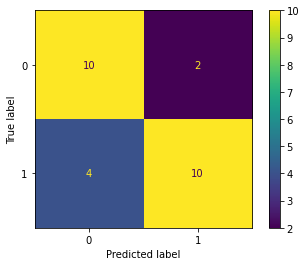

In [340]:
#confusion matrix
plot_confusion_matrix(grid,X_test,y_test);

- Our model have correctly classify `20` observation out of `26` and we can see the accuracy of the model = (total correct classification/ total observations)*100 =(20/26)*100= `77%`
- `True Negative (TN)`: The model has predicted correctly 10 observations as NON-ICU 
- `True Positive (TP)`: The model has predicted correctly 10 observations as ICU 
- `False Positive (FP)`:The model has predicted 2 observations as ICU while they are NON-ICU
- `False Negative (FN)`:The model has predicted 4 observations as NON-ICU while they are ICU.

Based on this objective, its critical to misclassify the ICU as NON-ICU, and our model should have lower FN.

`Misclassification Rate`: it describe how often our model is wrong in prediction the classification. this rate should be lower to have better model.
Misclassification Rate=((FP+FN)/total)*100= `23%`
- `Precision`: its a measure how often the model is correct when it predict ICU or 1: (TP/Predicted ICU)=10/12=`0.83`
- `recall`: its a measure of how often the model predict ICU  when its acually ICU: (TP/actual ICU)=10/14= `0.71`
the higher the recall the better the model.
- `F1 score`: is the harmonic mean of the precision and recall =Precision*recall/(Precision+recall)=`0.71`
the higher F1 score is the better.


In [341]:
print(classification_report(y_test,grid_pred))

              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       0.83      0.71      0.77        14

    accuracy                           0.77        26
   macro avg       0.77      0.77      0.77        26
weighted avg       0.78      0.77      0.77        26



In [342]:
#accuracy of the PCA model
round(accuracy_score(y_test,grid_pred) ,2)

0.77

In [343]:
# precision_score for PCA model
round(precision_score(y_test,grid_pred),2)

0.83

In [344]:
#recall_score for PCA model
round(recall_score(y_test,grid_pred),2)

0.71

In [345]:
#f1_score for PCA model
round(f1_score(y_test,grid_pred),2)

0.77

### 5.2 feature selection from RF model Predictions

In [346]:
grid_prediction = grid2.predict(X2_test)

__Confusion_matrix is used to show summarized result of Prediction vs Actual values and it quick way to see where our model misclassify in while making predictions__.

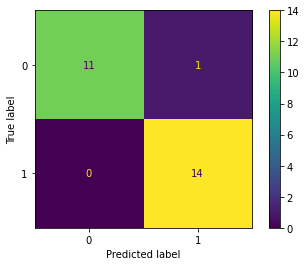

In [348]:
# Confusion_matrix
plot_confusion_matrix(grid2,X2_test,y2_test);

In [350]:
print(classification_report(y2_test,grid_prediction))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.93      1.00      0.97        14

    accuracy                           0.96        26
   macro avg       0.97      0.96      0.96        26
weighted avg       0.96      0.96      0.96        26



- Our model have correctly classify `25` observation out of `26` and we can see the accuracy of the model = (total correct classification/ total observations)*100 =(25/26)*100= `96%`
- `True Negative (TN)`: The model has predicted correctly 11 observations as NON-ICU 
- `True Positive (TP)`: The model has predicted correctly 14 observations as ICU 
- `False Positive (FP)`:The model has predicted 1 observations as ICU while they are NON-ICU.
- `False Negative (FN)`:The model has predicted 0 observations as NON-ICU while they are ICU.

Based on this objective, its critical to misclassify the ICU as NON-ICU, and our model have zero FN.

`Misclassification Rate`: it describe how often our model is wrong in prediction the classification. this rate should be lower to have better model.
Misclassification Rate=((FP+FN)/total)*100= `3.8%`
- `Precision`: its a measure how often the model is correct when it predict ICU or 1: (TP/Predicted ICU)=14/15=`0.93`
- `recall`: its a measure of how often the model predict ICU  when its acually ICU: (TP/actual ICU)=14/14= `1`
the higher the recall the better the model.
- `F1 score`: is the harmonic mean of the precision and recall =Precision*recall/(Precision+recall)=`0.96`
the higher F1 score is the better.


## 6. Discussion

Below is the summarized steps used to implement the model:
- EDA analysis and cleaning the data
- first method PCA:
    - Applying PCA in order to Reduce the dimensions of the dataset to simplify the model and reduce the complexity.
- Second method (feature selection from RF)
- Splitting the data with taking in considration the characteristics or attributes of the members in Gender and Severity using Stratify sampling technique.
- Applying SVM classifier on our data.
- Tuning the hyperparameters.
- validating our accuracy using KFold cross-validation technique.
- making predictions on unseen data.

As discussed earlier, reducing the dataset dimensions using PCA is useful for simplifying our model, reducing the computational time and complexity, and avoiding overfitting. 
To build a good model, we should select PCA components that contain most of the data information. The recommended choosing PCA components that explain 85% of the variance, but since we have a low number of observations, we selected 10 components that explained 66% of the variance to avoid increasing the complexity of the model. Because of information lost by selecting only 10 components our model performance or accuracy was 76%. Comparing the PCA method to the Random Forest method, the PCA method is faster to implement when considering computational time for PCA and Random Forest algorithms. On the other hand, if we look to build an accurate model, selecting the top features from Random Forest which are highly correlated with the target variable and not redundant improved the accuracy of the model and generalized well.

The main limitations of RandomForest is that it have high computaional time when we select large number of trees and correlated features will be given similar and lowered importance, compared to what their importance would be if the tree was built without correlated counterparts. While PCA remove the multi-collinearity between independent features.

- So the best way is to choose top features extracted by RF and check the correlated features using correlation matrix and manually remove the correlated features.

SVM algorthim will not perform well in large dataset, but since we have low number of observations and we reduced the dimension of the dataset its a good choice to be used compared to other algorthims

## 7. Complexity


### 7.1 PCA model Complexity

- To analyze or evaluate the cost of implementating our machine learning model or the complexity of our code, we need to take in consideration the O notation of PCA implementation and the SVC algorithm.
- For PCA, the algorithm have two main computational steps:
    1- Computing Covariance matrix with O notation=  `O(p^2)*n)`
    2- Computing the eigenvalue decomposition in term of O notation= `O(p^3)`
    thus,the complexity of PCA is `O(min(p^3,n^3))` where `n` is the number of training observations and `p` is the number of features. the complexity will grow in polynomial for both features and observations.
- For SVM, training complexity or time in SVM algorithm= `O((n^2)*p+n^3)`,thus the complexity is assumed to be `O(n^3)` where `n` is the number of training observations and `p` is the number of features.
- which means the training time is polynomial and would grow very fast if we have more number of samples. since we have low number of samples, the choice of choosing SVC would be good.

- below are the computational time for PCA and training part

In [353]:
import time

In [356]:
# for PCA
start1 = time.time()

pca_model = PCA(n_components=10)
pca_10 = pca_model.fit_transform(df_norm)

end1 = time.time()

In [357]:
print("The time of execution of above PCA is :", end1-start1,'second')

The time of execution of above PCA is : 0.26749658584594727 second


In [358]:
# Computational time for SVC to train the model
start2 = time.time()

SV.fit(X_train,y_train)

end2 = time.time()


In [359]:
print("The time of execution of above SVC traing is :", end2-start2,'seconds')

The time of execution of above SVC traing is : 0.008005380630493164 seconds


### 7.2 feature selection from RF model Complexity

- To analyze or evaluate the cost of implementating our machine learning model or the complexity of our code, we need to take in consideration the O notation of RandomForest algorithm and the SVC algorithm since we use RF as feature selection and build the model using SVM.

- For RandomForest, the algorithm complexity depend on two factors, number of trees `(ntree)` and number of features `(p)`.

- training complexity or time in RF algorithm by O notation=  `O((n^2)*p*ntree))` where `n` is number of training observations.
- Run-time Complexity=O(depth of tree* ntree).
 
- For SVM, training complexity or time in SVM algorithm= `O(n^2p+n^3)`,thus the complexity is assumed to be `O(n^3)` where `n` is the number of training observations and `p` is the number of features.
- which means the training time is polynomial and would grow very fast if we have more number of samples. since we have low number of samples, the choice of choosing SVC would be good.

- below are the computational time for RF and SVC training part

In [361]:
# Computational time for RF to select the features
start3 = time.time()

model_RF.fit(x,y)

end3 = time.time()


In [362]:
print("The time of execution of above RF is :", end3-start3,'seconds')

The time of execution of above RF is : 19.97100281715393 seconds


In [363]:
# Computational time for SVC to train the model
start4 = time.time()
model.fit(X2_train,y2_train)
end4 = time.time()

In [364]:
print("The time of execution of above SVC traing is :", end4-start4,'seconds')

The time of execution of above SVC traing is : 0.007978677749633789 seconds
